# Prepare test simulation results for unit testing
- Run using version cNMF 1.6.0

In [56]:

import os
import pandas as pd
import numpy as np
from scipy.io import mmread
import scipy.sparse as sp
import scanpy as sc
from cnmf import cNMF

if not os.path.exists('example_PBMC'):
    os.mkdir('example_PBMC')
    
np.random.seed(14)

## Download the data and copy it to the directory ./example_PBMC

In [57]:
! wget -O example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
! tar -zxvf example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz    
! mv filtered_gene_bc_matrices example_PBMC
! rm  example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz

--2025-03-01 23:37:02--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
connected. to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... 
301 Moved Permanentlyaiting response... 
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2025-03-01 23:37:02--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
200 OKequest sent, awaiting response... 
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz’

example_PBMC/pbmc3k 100%[===================>]   7.27M  37.6MB/s    in 0.2s    

2025-03-01 23:37:02 (37.6 MB/s) - ‘example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]

x filtered

## Load the dataset as a sparse matrix into the Scanpy structure and then filter genes that aren't observed in  at least 3 cells, and cells with fewer than 200 genes detected

In [58]:
adata = sc.read_10x_mtx(
    'example_PBMC/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',
    cache=False)

adata.var_names_make_unique()

In [59]:
## Loaded data of 2700 PBMCs with 32738 genes
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [60]:
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells


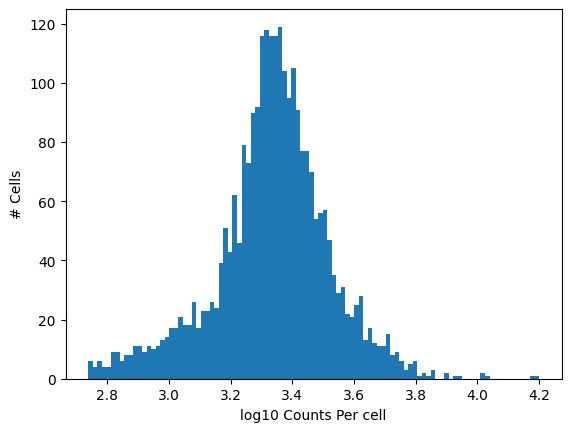

In [61]:
## plot log10 # counts per cell
plt.hist(np.log10(adata.obs['n_counts']), bins=100)
_ = plt.xlabel('log10 Counts Per cell')
_ = plt.ylabel('# Cells')

## Save the scanpy object to a file. This file will be passed as input to cNMF

In [62]:
count_adat_fn = 'example_PBMC/counts.h5ad'
sc.write(count_adat_fn, adata)

In [67]:
numiter=15 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numhvgenes=1000 ## Number of over-dispersed genes to use for running the actual factorizations

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = 'example_PBMC'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF'

## Specify the Ks to use as a space separated list in this case "5 6 7 8 9 10"
Ks = np.arange(7,10)

seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = 'example_PBMC/counts.h5ad'

In [68]:
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)

In [69]:
## Prepare the data, I.e. subset to 2000 high-variance genes, and variance normalize
cnmf_obj.prepare(counts_fn=countfn, components=Ks, n_iter=numiter, seed=seed, num_highvar_genes=numhvgenes)

/Users/dkotliar/mambaforge/envs/test_cnmf/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [70]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=1)

[Worker 0]. Starting task 0.
[Worker 0]. Starting task 1.
[Worker 0]. Starting task 2.
[Worker 0]. Starting task 3.
[Worker 0]. Starting task 4.
[Worker 0]. Starting task 5.
[Worker 0]. Starting task 6.
[Worker 0]. Starting task 7.
[Worker 0]. Starting task 8.
[Worker 0]. Starting task 9.
[Worker 0]. Starting task 10.
[Worker 0]. Starting task 11.
[Worker 0]. Starting task 12.
[Worker 0]. Starting task 13.
[Worker 0]. Starting task 14.
[Worker 0]. Starting task 15.
[Worker 0]. Starting task 16.
[Worker 0]. Starting task 17.
[Worker 0]. Starting task 18.
[Worker 0]. Starting task 19.
[Worker 0]. Starting task 20.
[Worker 0]. Starting task 21.
[Worker 0]. Starting task 22.
[Worker 0]. Starting task 23.
[Worker 0]. Starting task 24.
[Worker 0]. Starting task 25.
[Worker 0]. Starting task 26.
[Worker 0]. Starting task 27.
[Worker 0]. Starting task 28.
[Worker 0]. Starting task 29.
[Worker 0]. Starting task 30.
[Worker 0]. Starting task 31.
[Worker 0]. Starting task 32.
[Worker 0]. Starting

In [71]:
cnmf_obj.combine()

Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.


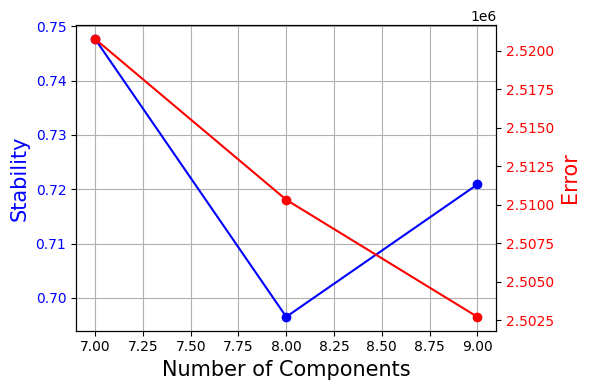

In [72]:
cnmf_obj.k_selection_plot(close_fig=False)

In [73]:
selected_K = 7
density_threshold = 0.1

In [74]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=False, close_clustergram_fig=False)

/Users/dkotliar/mambaforge/envs/test_cnmf/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [75]:
selected_K = 8
density_threshold = 0.1

In [76]:
cnmf_obj.consensus(k=selected_K, density_threshold=density_threshold, show_clustering=False, close_clustergram_fig=False)

/Users/dkotliar/mambaforge/envs/test_cnmf/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [78]:
! ls ./example_PBMC/pbmc_cNMF

cnmf_tmp
pbmc_cNMF.gene_spectra_score.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_score.k_8.dt_0_1.txt
pbmc_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt
pbmc_cNMF.gene_spectra_tpm.k_8.dt_0_1.txt
pbmc_cNMF.k_selection.png
pbmc_cNMF.k_selection_stats.df.npz
pbmc_cNMF.overdispersed_genes.txt
pbmc_cNMF.spectra.k_7.dt_0_1.consensus.txt
pbmc_cNMF.spectra.k_8.dt_0_1.consensus.txt
pbmc_cNMF.starcat_spectra.k_7.dt_0_1.txt
pbmc_cNMF.starcat_spectra.k_8.dt_0_1.txt
pbmc_cNMF.usages.k_7.dt_0_1.consensus.txt
pbmc_cNMF.usages.k_8.dt_0_1.consensus.txt


In [79]:
! ls ./example_PBMC

counts.h5ad               filtered_gene_bc_matrices pbmc_cNMF


In [80]:
! rm -Rf ./example_PBMC/filtered_gene_bc_matrices/

In [81]:
! tar -czvf example_pbmc_results_20250301.tar.gz ./example_PBMC/*

a ./example_PBMC/counts.h5ad
a ./example_PBMC/pbmc_cNMF
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.k_selection.png
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.gene_spectra_score.k_7.dt_0_1.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.k_selection_stats.df.npz
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.overdispersed_genes.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.gene_spectra_score.k_8.dt_0_1.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.spectra.k_8.dt_0_1.consensus.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.spectra.k_7.dt_0_1.consensus.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.starcat_spectra.k_7.dt_0_1.txt
a ./example_PBMC/pbmc_cNMF/cnmf_tmp
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.usages.k_8.dt_0_1.consensus.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.gene_spectra_tpm.k_7.dt_0_1.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.usages.k_7.dt_0_1.consensus.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.starcat_spectra.k_8.dt_0_1.txt
a ./example_PBMC/pbmc_cNMF/pbmc_cNMF.gene_spectra_tpm.k_8.dt_0_1.txt
a ./example_PBMC/pbmc_cNMF/cnmf_tmp/pb